In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [ ]:
import torchvision.datasets as datasets
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(root="data", download=True, transform=ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 162075273.54it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 40965740.22it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41009062.91it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17009400.69it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
# Viewing the shape of an image item and the label associated with it
img, label = train_data[0]
img.shape, label

(torch.Size([1, 28, 28]), 5)

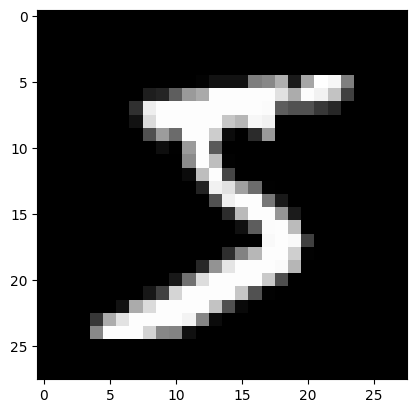

In [ ]:
# Plotting an image item using pyplot
img, label = train_data[0]
plt.imshow(img.permute(1,2,0), cmap="gray")

In [ ]:
# Splitting dataset in training and validation set
train_set, val_set = random_split(train_data, [50000, 10000])
len(train_set), len(val_set)

(50000, 10000)

In [ ]:
# Define batch_size and create DataLoaders
# FAQs
## Why set shuffle=True? This is to ensure that in every pass of the load operation, the data
## shuffled and a random set of batch_size image items is selected to be loaded. (Sometimes, the
## dataset may have items in a certain pattern or order. Just to break that.)

batch_size = 100
train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_set, batch_size, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Defining the Neural Network
# There are 2 mandatory methods that you need to implement:
## __init__ and forward

class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)

    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions, triggers forward(self, xb)
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions, triggers forward(self, xb)
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

The next Section is dedicated to GPU specific code. To ensure that we are using a GPU, if available, for the computations.

In [ ]:
# To check if GPU is available
torch.cuda.is_available()

True

In [ ]:
# Helper function to ensure that our code uses GPU if available, else CPU.
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
# Check what device was selected in the step above
device = get_default_device()
device

device(type='cuda')

In [ ]:
# Function to move the data to the chosen device
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
# Create a DeviceDataLoader class to wrap our existing loaders, and move data to chosen device
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
# Wrap our existing data loaders using DeviceDataLoader
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

The following section is dedicated to training the model

In [ ]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
# Instantiate the model class and load onto the selected device
model = MnistModel(784, hidden_size=32, out_size=10)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.2996253967285156, 'val_acc': 0.12210001051425934}]

In [ ]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2001, val_acc: 0.9418
Epoch [1], val_loss: 0.1648, val_acc: 0.9498
Epoch [2], val_loss: 0.1349, val_acc: 0.9593
Epoch [3], val_loss: 0.1321, val_acc: 0.9604
Epoch [4], val_loss: 0.1244, val_acc: 0.9637


In [ ]:
history += fit(5, 0.2, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1077, val_acc: 0.9680
Epoch [1], val_loss: 0.1110, val_acc: 0.9661
Epoch [2], val_loss: 0.1051, val_acc: 0.9681
Epoch [3], val_loss: 0.1052, val_acc: 0.9689
Epoch [4], val_loss: 0.1030, val_acc: 0.9704


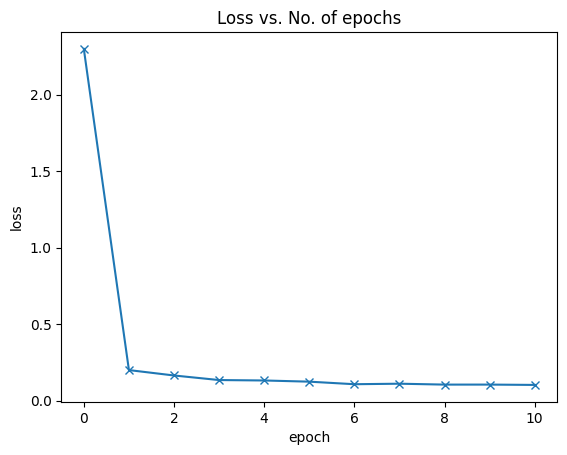

In [ ]:
# Plot the loss
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x') # '-x' -> x the data points and draw a line through them
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

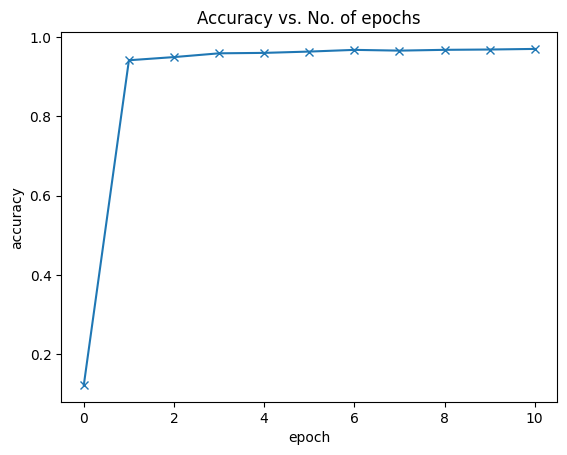

In [ ]:
# Plot the accuracy
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

The following section contains function that will be called when we want to make a prediction.

In [ ]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

In [ ]:
import pickle

# Save the model to a file using pickle
with open('digit-classification-nn.pkl', 'wb') as file:
    pickle.dump(model, file)